In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT LIBRARIES/DATASETS

In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Model, load_model, Sequential
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
datafolder = "/content/drive/MyDrive/data2/Images"
os.chdir("/content/drive/MyDrive/data2")

In [5]:
# Check the number of images in the dataset
data = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('Images', i))
  for j in train_class:
    img = os.path.join('Images', i, j)
    data.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(data)))


Number of train images : 3672 



# PERFORM DATA EXPLORATION AND DATA VISUALIZATION

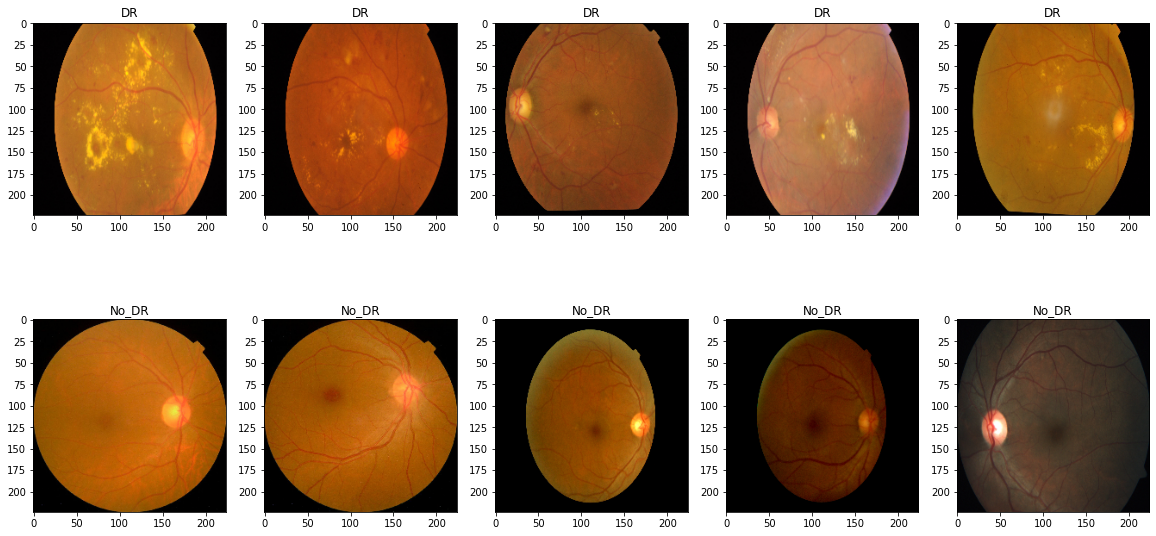

In [7]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(2, 5, figsize = (20, 10))
count = 0
for i in os.listdir(datafolder):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('Images', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('Images', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1



In [8]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
total = 0;
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('Images', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))
  total+=len(train_class)  
print("\n\tNumber of total images = {}".format(total))

Number of images in DR = 1857 

Number of images in No_DR = 1815 


	Number of total images = 3672


In [9]:
retina_df = pd.DataFrame({'Image': data,'Labels': label})
retina_df

,Image,Labels
0,Images/DR/4a0890b08532.png,DR
1,Images/DR/523d0c2cb4d6.png,DR
2,Images/DR/5a11d21c2828.png,DR
3,Images/DR/a125377fb985.png,DR
4,Images/DR/b8ac328009e0.png,DR
...,...,...
3667,Images/No_DR/6cb96a6fb029.png,No_DR
3668,Images/No_DR/6bb30ec3231a.png,No_DR
3669,Images/No_DR/9a56cfb980ec.png,No_DR
3670,Images/No_DR/633fe9dbaf39.png,No_DR


# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [10]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.27)

In [11]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Creating datagenerator for training, validation and test dataset.
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2278 validated image filenames belonging to 2 classes.
Found 402 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


# BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [13]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [14]:
input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (9,9), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

#Max Pooling

X = MaxPooling2D((2,2), strides=(2,2), padding="valid", name = 'Maximum_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(2, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 127, 127, 64  15616       ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [15]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [16]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=30)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/FY_BTech_Project/Saved Models/bc_saved_model_1.h5", verbose = 1, save_best_only=True)

In [18]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7912 
Epoch 1: val_loss improved from inf to 0.83608, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/bc_saved_model_1.h5
71/71 [==============================] - 916s 13s/step - loss: 0.7967 - accuracy: 0.7912 - val_loss: 0.8361 - val_accuracy: 0.5104
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.8344
Epoch 2: val_loss did not improve from 0.83608
71/71 [==============================] - 45s 640ms/step - loss: 0.5718 - accuracy: 0.8344 - val_loss: 1.1966 - val_accuracy: 0.5000
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8749
Epoch 3: val_loss did not improve from 0.83608
71/71 [==============================] - 48s 669ms/step - loss: 0.4094 - accuracy: 0.8749 - val_loss: 1.6385 - val_accuracy: 0.5052
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 

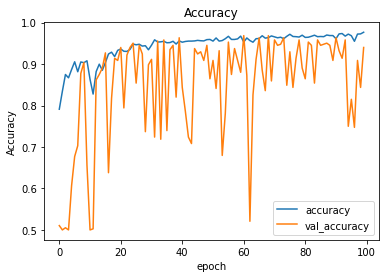

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc = 'lower right')
plt.show()

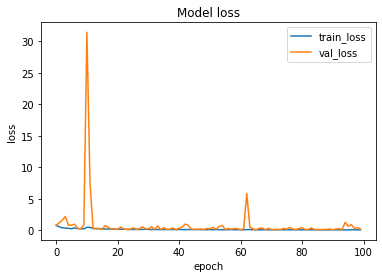

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [21]:
# Evaluate the performance of the model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/FY_BTech_Project/Saved Models/bc_saved_model_1.h5")
evaluate = saved_model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

31/31 [==============================] - 337s 11s/step - loss: 0.1061 - accuracy: 0.9698


In [41]:
print('Accuracy Test : {:.4f} %'.format(evaluate[1]*100))
print('Loss Test : {:.4f}'.format(evaluate[0]))

Accuracy Test : 96.9758 %
Loss Test : 0.1061


In [42]:
# Assigning label names to the corresponding indexes
labels = {0: 'DR', 1: 'No_DR'}

In [43]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 [==============================] - 0s 18ms/step


In [44]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {:.4f} %".format(score*100))

Test Accuracy : 96.9758 %


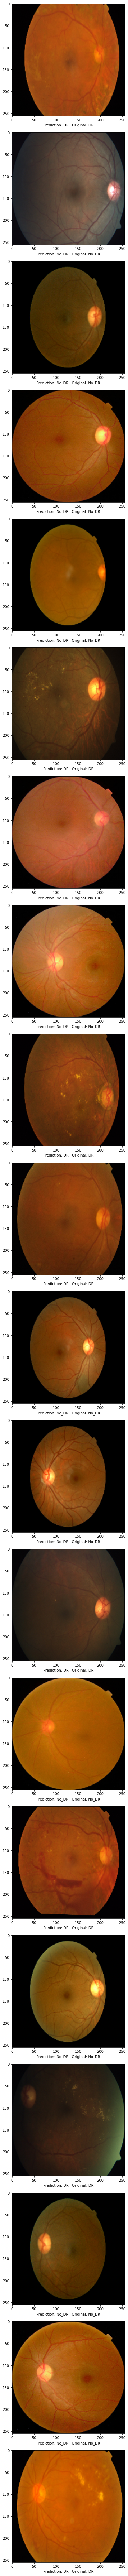

In [46]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [47]:
from sklearn.metrics import roc_curve,auc
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

          DR       0.98      0.96      0.97       495
       No_DR       0.96      0.98      0.97       497

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992



Text(0.5, 1.0, 'Confusion_matrix')

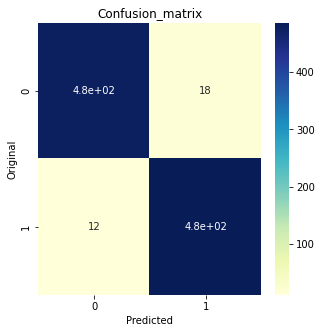

In [48]:
import seaborn as sns
plt.figure(figsize = (5,5))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu")

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [49]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
sensitivity = (TP/(TP + FN))
specificity = (TN/(TN + FP))

print("Sensitivity : "+str(sensitivity[0]))
print("Specificity : "+str(specificity[0]))

Sensitivity : 0.9636363636363636
Specificity : 0.9758551307847082


In [50]:
from sklearn.metrics import roc_auc_score

In [56]:
list1=[]
list2=[]

for i in original:
  if(i == "DR"):
    list1.append(1)
  else:
    list1.append(0)
for i in prediction:
  if(i == "DR"):
    list2.append(1)
  else:
    list2.append(0)

auc = roc_auc_score(list1,list2)
print('ROC AUC: %f' % auc)

ROC AUC: 0.969746


In [58]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(list1,list2)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.939514
